# Demo: Giảm chiều dữ liệu MNIST bằng PCA (SVD) và Phân loại bằng MLP

Notebook này minh họa quy trình ứng dụng thuật toán SVD để giảm chiều dữ liệu (PCA) và sử dụng dữ liệu đã giảm chiều để huấn luyện mô hình mạng nơ-ron nhân tạo (MLP) cho bài toán phân loại chữ số viết tay MNIST.

**Quy trình thực hiện:**
1.  Tải bộ dữ liệu MNIST (784 đặc trưng).
2.  Tiền xử lý: Chuẩn hóa dữ liệu (Centering).
3.  Giảm chiều dữ liệu: Sử dụng SVD để thực hiện PCA, giảm từ 784 xuống 50 đặc trưng.
4.  Xây dựng mô hình: Multi-layer Perceptron (MLP) với 1 lớp ẩn (100 neuron).
5.  Huấn luyện và đánh giá: Đo độ chính xác trên tập kiểm tra.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import time

# Cấu hình hiển thị
%matplotlib inline
np.random.seed(42)

## 1. Tải và Tiền xử lý dữ liệu MNIST

Chúng ta sử dụng bộ dữ liệu MNIST gồm 70,000 ảnh chữ số viết tay (0-9). Mỗi ảnh có kích thước 28x28 pixel, được duỗi thành vector 784 chiều.

Đang tải dữ liệu MNIST (có thể mất vài phút)...
Kích thước dữ liệu gốc: (70000, 784)
Số lượng nhãn: (70000,)
Kích thước dữ liệu gốc: (70000, 784)
Số lượng nhãn: (70000,)


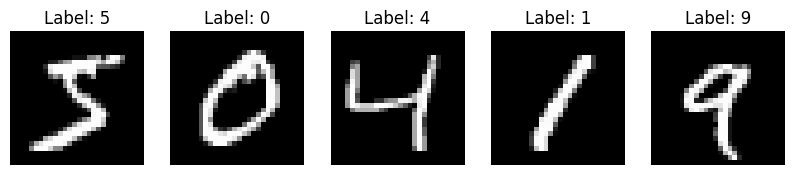

In [9]:
print("Đang tải dữ liệu MNIST (có thể mất vài phút)...")
# Tải dữ liệu từ OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X = mnist.data
y = mnist.target.astype(int)

print(f"Kích thước dữ liệu gốc: {X.shape}")
print(f"Số lượng nhãn: {y.shape}")

# Hiển thị một vài ảnh mẫu
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.show()

## 2. Triển khai PCA bằng thuật toán Jacobi V2 (Custom Implementation)

Thay vì sử dụng thư viện có sẵn (`np.linalg.svd`), chúng ta sẽ sử dụng thuật toán **Parallel Norm-Reducing Jacobi** đã được triển khai trong dự án (C/C++) để tính toán các thành phần chính.

Quy trình:
1.  Tính ma trận hiệp phương sai: $C = \frac{1}{m-1} X^T X$.
2.  Sử dụng thuật toán Jacobi V2 để tìm trị riêng và vector riêng của $C$.
3.  Sắp xếp các vector riêng theo trị riêng giảm dần.
4.  Chọn $k$ vector riêng đầu tiên làm ma trận chiếu.

In [10]:
import ctypes
import os
import sys
import shutil

# Tìm kiếm file DLL
possible_paths = [
    os.path.abspath(os.path.join(os.getcwd(), '../bin/jacobi_v2.dll')), # Nếu cwd là thư mục test
    os.path.abspath(os.path.join(os.getcwd(), 'bin/jacobi_v2.dll')),    # Nếu cwd là thư mục gốc
    r"e:\subjects\parallel_computing\final_project\bin\jacobi_v2.dll"   # Đường dẫn tuyệt đối
]

dll_path = None
for p in possible_paths:
    if os.path.exists(p):
        dll_path = p
        break

if dll_path is None:
    raise FileNotFoundError(f"Không tìm thấy file jacobi_v2.dll. Đã tìm tại: {possible_paths}")

print(f"Loading DLL from: {dll_path}")

# Trên Windows Python 3.8+, cần thêm đường dẫn DLL vào search path nếu nó phụ thuộc vào DLL khác (như libgomp)
if os.name == 'nt' and hasattr(os, 'add_dll_directory'):
    try:
        # 1. Thêm thư mục chứa DLL chính
        os.add_dll_directory(os.path.dirname(dll_path))
        
        # 2. Tự động tìm và thêm thư mục bin của MinGW (nơi chứa libgomp-1.dll, libgcc_s_seh-1.dll, ...)
        gcc_path = shutil.which('gcc')
        if gcc_path:
            mingw_bin = os.path.dirname(gcc_path)
            print(f"Found MinGW bin at: {mingw_bin}")
            os.add_dll_directory(mingw_bin)
        else:
            print("Warning: Không tìm thấy 'gcc' trong PATH. Các thư viện phụ thuộc (như libgomp) có thể bị thiếu.")
            
    except Exception as e:
        print(f"Warning when adding DLL directories: {e}")

try:
    jacobi_lib = ctypes.CDLL(dll_path)
    
    # Định nghĩa signature hàm C
    # void compute_eigenvalues_parallel(int n, const double* A_in, double* w, double* V_out);
    jacobi_lib.compute_eigenvalues_parallel.argtypes = [
        ctypes.c_int,
        np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
        np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
        np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
    ]
    jacobi_lib.compute_eigenvalues_parallel.restype = None
    print("DLL loaded successfully!")
except Exception as e:
    print(f"Error loading DLL: {e}")
    # Gợi ý debug
    print("Gợi ý: Đảm bảo rằng thư mục 'bin' của MinGW (chứa libgomp-1.dll) đã được thêm vào PATH hoặc add_dll_directory.")
    raise e

Loading DLL from: e:\subjects\parallel_computing\final_project\bin\jacobi_v2.dll
Found MinGW bin at: C:\Strawberry\c\bin
DLL loaded successfully!


In [11]:
# 1. Centering dữ liệu
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

# 2. Tính ma trận hiệp phương sai C = (X^T * X) / (m - 1)
print("Đang tính ma trận hiệp phương sai...")
m, n = X_centered.shape
# Sử dụng np.dot cho nhanh (BLAS)
C = np.dot(X_centered.T, X_centered) / (m - 1)
print(f"Kích thước ma trận hiệp phương sai: {C.shape}")

# Chuẩn bị dữ liệu cho hàm C
n_features = C.shape[0]
C_flat = C.flatten().astype(np.float64)
eigenvalues = np.zeros(n_features, dtype=np.float64)
eigenvectors_flat = np.zeros(n_features * n_features, dtype=np.float64)

print("Đang chạy thuật toán Jacobi V2 Parallel (C++)...")
start_time = time.time()

# Gọi hàm C
jacobi_lib.compute_eigenvalues_parallel(n_features, C_flat, eigenvalues, eigenvectors_flat)

end_time = time.time()
print(f"Thời gian tính Eigenvalues (Jacobi V2): {end_time - start_time:.2f} giây")

# Reshape eigenvectors về (n, n)
# Lưu ý: Hàm C trả về eigenvectors theo cột (column-major) hoặc hàng?
# Header file says: "stored as columns".
# Nếu flat array là column-major, thì khi reshape trong numpy (row-major default), ta cần cẩn thận.
# Tuy nhiên, nếu C code viết V[i*n + j] thì đó là row-major trong C.
# Hãy giả sử output là row-major tương thích với C array thông thường.
V = eigenvectors_flat.reshape((n_features, n_features))

# 3. Sắp xếp trị riêng và vector riêng giảm dần
idx = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[idx]
V_sorted = V[:, idx]

# 4. Chọn k thành phần chính
k = 50
V_k = V_sorted[:, :k]

print(f"Kích thước ma trận chiếu V_k: {V_k.shape}")

# Chiếu dữ liệu
X_reduced = np.dot(X_centered, V_k)
print(f"Kích thước dữ liệu sau giảm chiều: {X_reduced.shape}")

Đang tính ma trận hiệp phương sai...
Kích thước ma trận hiệp phương sai: (784, 784)
Đang chạy thuật toán Jacobi V2 Parallel (C++)...
Kích thước ma trận hiệp phương sai: (784, 784)
Đang chạy thuật toán Jacobi V2 Parallel (C++)...
Thời gian tính Eigenvalues (Jacobi V2): 16.76 giây
Kích thước ma trận chiếu V_k: (784, 50)
Thời gian tính Eigenvalues (Jacobi V2): 16.76 giây
Kích thước ma trận chiếu V_k: (784, 50)
Kích thước dữ liệu sau giảm chiều: (70000, 50)
Kích thước dữ liệu sau giảm chiều: (70000, 50)


### Trực quan hóa dữ liệu tái tạo (Reconstruction)
Để kiểm tra xem 50 thành phần có giữ lại đủ thông tin không, ta thử tái tạo lại ảnh gốc từ dữ liệu giảm chiều:
$$ X_{reconstructed} = X_{reduced} \cdot V_k^T + \mu $$

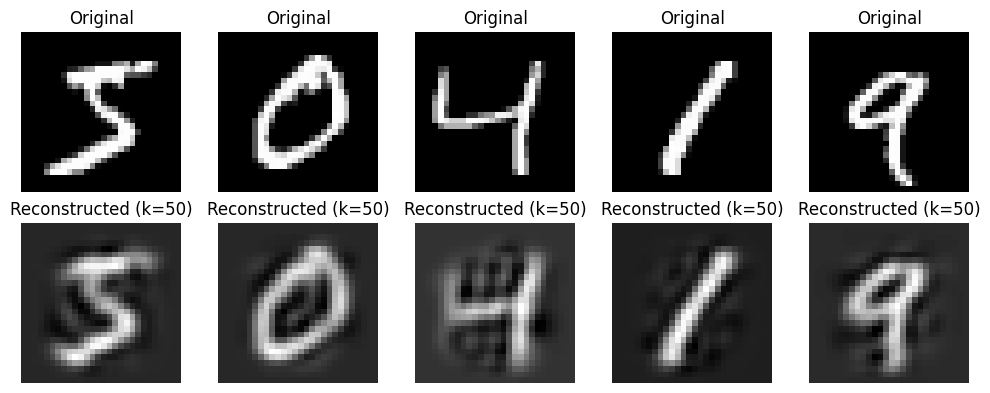

In [12]:
X_reconstructed = np.dot(X_reduced, V_k.T) + X_mean

plt.figure(figsize=(10, 4))
for i in range(5):
    # Ảnh gốc
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Ảnh tái tạo
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title(f"Reconstructed (k={k})")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Xây dựng và Huấn luyện mô hình MLP

Sử dụng `MLPClassifier` từ thư viện scikit-learn với cấu hình:
-   Hidden layer: 100 neurons
-   Activation: ReLU (mặc định)
-   Solver: Adam (mặc định)
-   Max iter: 200

In [13]:
# Chia tập dữ liệu (Train: 80%, Test: 20%)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")

# Khởi tạo mô hình MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42, verbose=True)

print("\nBắt đầu huấn luyện mô hình MLP...")
start_train = time.time()
mlp.fit(X_train, y_train)
end_train = time.time()

print(f"Thời gian huấn luyện: {end_train - start_train:.2f} giây")

Kích thước tập huấn luyện: (56000, 50)
Kích thước tập kiểm tra: (14000, 50)

Bắt đầu huấn luyện mô hình MLP...
Iteration 1, loss = 7.16719612
Iteration 1, loss = 7.16719612
Iteration 2, loss = 2.37887271
Iteration 2, loss = 2.37887271
Iteration 3, loss = 1.63678836
Iteration 3, loss = 1.63678836
Iteration 4, loss = 1.26053823
Iteration 4, loss = 1.26053823
Iteration 5, loss = 1.00325332
Iteration 5, loss = 1.00325332
Iteration 6, loss = 0.85612643
Iteration 6, loss = 0.85612643
Iteration 7, loss = 0.71036489
Iteration 7, loss = 0.71036489
Iteration 8, loss = 0.61124905
Iteration 8, loss = 0.61124905
Iteration 9, loss = 0.56439383
Iteration 9, loss = 0.56439383
Iteration 10, loss = 0.49155918
Iteration 10, loss = 0.49155918
Iteration 11, loss = 0.44832924
Iteration 11, loss = 0.44832924
Iteration 12, loss = 0.38670842
Iteration 12, loss = 0.38670842
Iteration 13, loss = 0.36635365
Iteration 13, loss = 0.36635365
Iteration 14, loss = 0.36119920
Iteration 14, loss = 0.36119920
Iteration 1

## 4. Đánh giá Hiệu năng

Đánh giá mô hình trên tập kiểm tra (Test set) để xem độ chính xác khi phân loại các chữ số dựa trên dữ liệu đã giảm chiều.

Độ chính xác trên tập kiểm tra: 97.11%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1343
           1       0.99      0.99      0.99      1600
           2       0.96      0.98      0.97      1380
           3       0.97      0.96      0.97      1433
           4       0.96      0.97      0.97      1295
           5       0.96      0.97      0.96      1273
           6       0.98      0.98      0.98      1396
           7       0.98      0.97      0.97      1503
           8       0.97      0.95      0.96      1357
           9       0.96      0.95      0.95      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



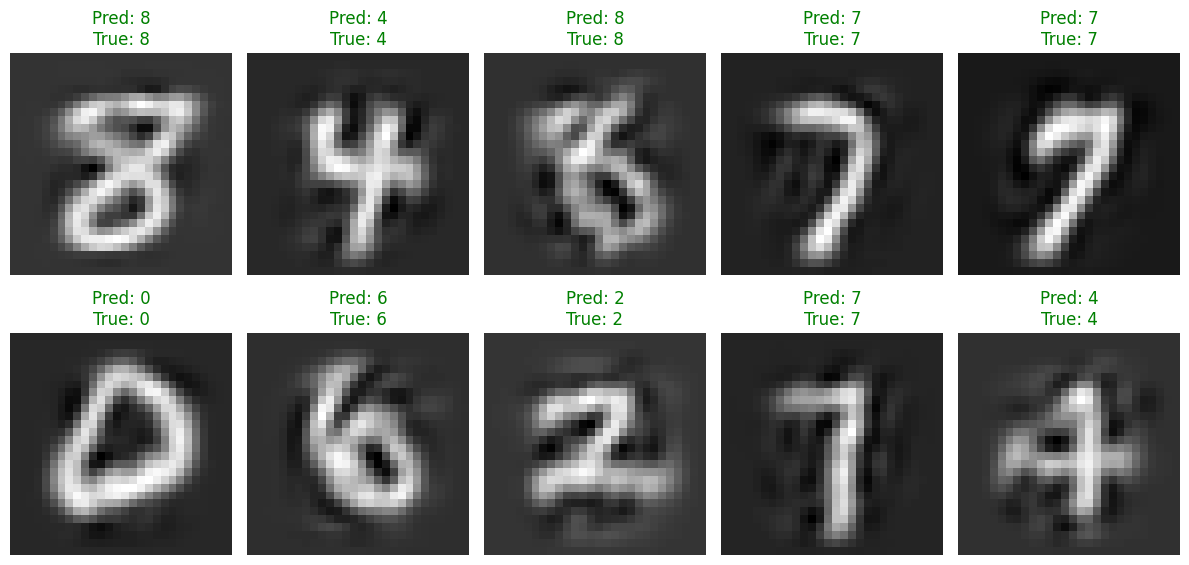

In [14]:
# Dự đoán trên tập test
y_pred = mlp.predict(X_test)

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác trên tập kiểm tra: {accuracy * 100:.2f}%")

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Hiển thị một số kết quả dự đoán
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Lấy lại ảnh gốc từ tập test (cần map lại index nếu muốn chính xác ảnh gốc, ở đây minh họa concept)
    # Do X_test là dữ liệu giảm chiều, ta tái tạo lại để hiển thị
    img_reconstructed = np.dot(X_test[i], V_k.T) + X_mean
    
    plt.imshow(img_reconstructed.reshape(28, 28), cmap='gray')
    
    color = 'green' if y_pred[i] == y_test[i] else 'red'
    plt.title(f"Pred: {y_pred[i]}\nTrue: {y_test[i]}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

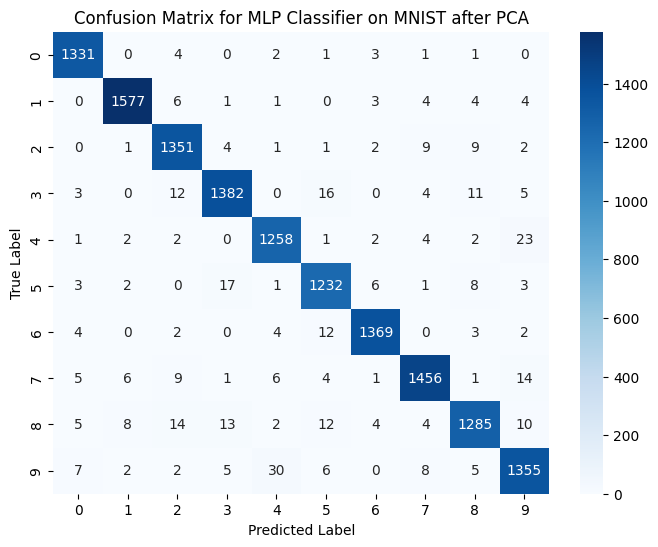

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP Classifier on MNIST after PCA')
plt.show()